# Qualitative Experiments with LXDR
In this notebook, we are presenting an example on how we can use LXDR in two actual scenarios. 

In [1]:
import math
import numpy as np
import site, pprint
import pandas as pd
import seaborn as sns
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, KernelPCA
from sklearn.linear_model import Ridge
from lxdr import LXDR

## Use Case 1: Regression

We will use the Diabetes dataset where each sample has 10 features. We will use PCA to reduce the dimensions to 8, and then we will train a Ridge regression model to make predictions!

In [2]:
diabetes = datasets.load_diabetes()
initial_data = diabetes.data
initial_predictions = diabetes.target

#Reduce to 8 dimensions
components = 8

#Random Sample
sample = 0

Before applying PCA, we have to split the data to train-test sets, and we scale them to [-1,1] !

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MaxAbsScaler
X_train, X_test, y_train, y_test = train_test_split(initial_data, initial_predictions, test_size=0.33, random_state=42)
scaler = MaxAbsScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
mean = X_train.mean(axis=0)

We prepare PCA based on the train set, and we transform both the train and test sets, respectively.

In [4]:
pca = PCA(n_components=components)
pca.fit(X_train)
X_train_T = pca.transform(X_train)
X_test_T = pca.transform(X_test)

Finally, we train the ML model

In [5]:
clf = Ridge().fit(X_train_T, y_train)

We evaluate the performance of the model on the test set!

In [6]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test, clf.predict(X_test_T))

42.08117659059927

We select a random instance and we take a prediction from the ML model

In [7]:
print('Instance: ', [round(i,2) for i in list(X_test[0])])
print('Reduced Representation: ', [round(i,2) for i in list(X_test_T[0])])
print('Prediction: ',clf.predict(X_test_T)[0])

Instance:  [0.41, -0.88, -0.04, -0.12, 0.81, 0.63, 0.11, 0.19, 0.24, -0.04]
Reduced Representation:  [-0.73, -0.86, -0.07, -0.88, 0.17, -0.07, -0.1, -0.06]
Prediction:  140.03376729388197


We ask for the ML model's interpretation! The global weights are the following:

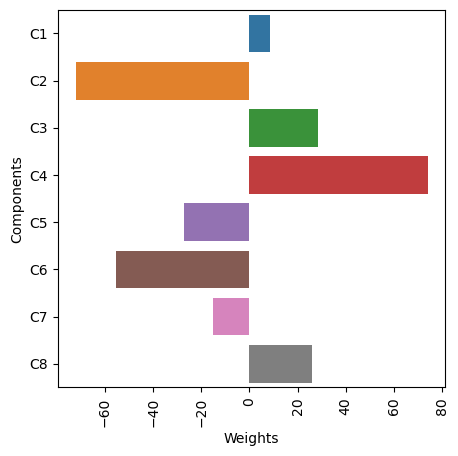

[8.73, -72.23, 28.48, 74.1, -27.07, -55.25, -15.1, 25.95]

In [8]:
model_weights = pd.DataFrame({"Components": ['C'+str(i) for i in range(1,9)], "Weights": list(clf.coef_)}) #If you want to display global structure remove the * INSTANCE
#model_weights = model_weights.sort_values(by="Weights", ascending=False)
#model_weights = model_weights[(model_weights["Weights"] != 0)]
#Moreover if there are many features you can take head 10 and tail 10 of the dataframe and display only 20 features
plt.figure(num=None, figsize=(5, 5), dpi=100, facecolor='w', edgecolor='k')
sns.barplot(x="Weights", y="Components", data=model_weights)
plt.xticks(rotation=90)
plt.show()
[round(i,2) for i in list(clf.coef_)]

While the local interpretation is the following:

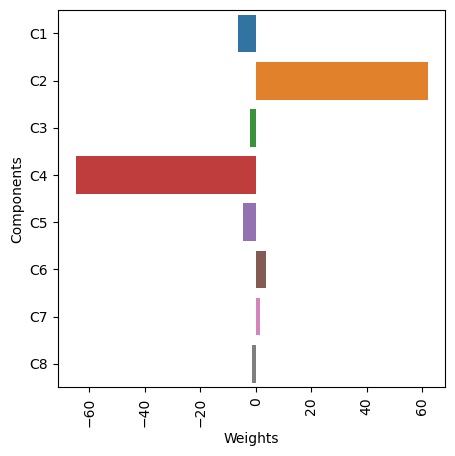

[-6.38, 62.08, -1.9, -65.04, -4.51, 3.85, 1.47, -1.51]

In [9]:
model_weights = pd.DataFrame({"Components": ['C'+str(i) for i in range(1,9)], "Weights": list(clf.coef_*X_test_T[0])}) #If you want to display global structure remove the * INSTANCE
#model_weights = model_weights.sort_values(by="Weights", ascending=False)
#model_weights = model_weights[(model_weights["Weights"] != 0)]
#Moreover if there are many features you can take head 10 and tail 10 of the dataframe and display only 20 features
plt.figure(num=None, figsize=(5, 5), dpi=100, facecolor='w', edgecolor='k')
sns.barplot(x="Weights", y="Components", data=model_weights)
plt.xticks(rotation=90)
plt.show()
[round(i,2) for i in list(clf.coef_ * X_test_T[0])]

We can see that the first component is the most influencing! Let's see which original features influenced this component?

In [10]:
local = np.dot(clf.coef_*X_test_T[0],pca.components_) + pca.mean_
local

array([ -7.80982938,  10.7068943 , -40.04238207, -61.33886564,
         9.62046746,  10.73429349,  16.51167897,  -6.80640027,
       -28.57665667, -35.78565416])

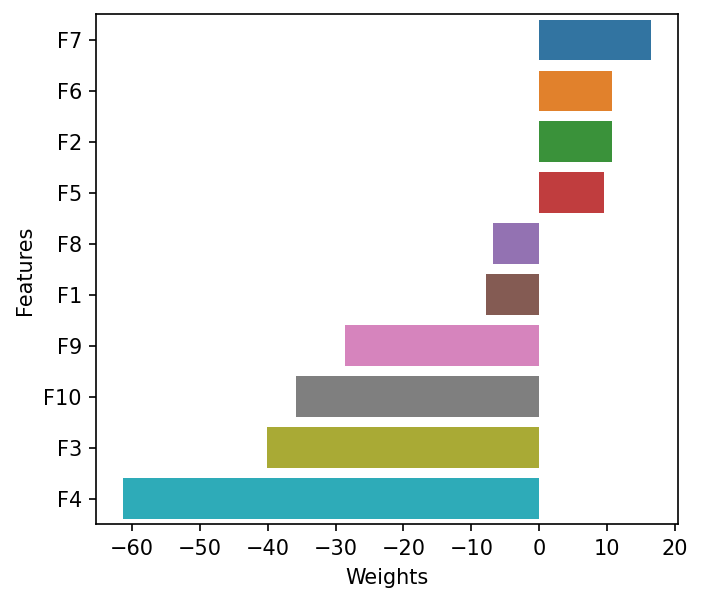

[-6.38, 62.08, -1.9, -65.04, -4.51, 3.85, 1.47, -1.51]

In [11]:
model_weights = pd.DataFrame({"Features": ['F'+str(i) for i in range(1,11)], "Weights": list(local)}) #If you want to display global structure remove the * INSTANCE
model_weights = model_weights.sort_values(by="Weights", ascending=False)
#model_weights = model_weights[(model_weights["Weights"] != 0)]
#Moreover if there are many features you can take head 10 and tail 10 of the dataframe and display only 20 features
plt.figure(num=None, figsize=(5, 4.5), dpi=150, facecolor='w', edgecolor='k')
sns.barplot(x="Weights", y="Features", data=model_weights)
plt.xticks(rotation=0)
plt.show()
[round(i,2) for i in list(clf.coef_ * X_test_T[0])]

It is visible that the 4th feature, with weight arround -65 is the most negatively influencing. We also present all the relations between the components and the original features

In [12]:
[-6.38, 62.08, -1.9, -65.04, -4.51, 3.85, 1.47, -1.51]
count = 1
print('     C1  &  C2  &  C3  &   C4  &   C5  &  C6  &   C7  &  C8')
for comp in pca.components_.T:
    print('F'+str(count)+': ' + ' & '.join([str(round(i,2)) for i in comp]))
    count = count + 1

     C1  &  C2  &  C3  &   C4  &   C5  &  C6  &   C7  &  C8
F1: 0.1 & -0.35 & -0.82 & -0.18 & -0.37 & -0.08 & -0.09 & -0.03
F2: 0.96 & 0.24 & -0.01 & -0.03 & 0.06 & 0.01 & 0.03 & 0.09
F3: 0.05 & -0.3 & 0.18 & 0.29 & -0.13 & -0.2 & -0.49 & 0.7
F4: 0.1 & -0.34 & -0.19 & 0.57 & 0.59 & -0.26 & -0.02 & -0.32
F5: 0.04 & -0.36 & 0.1 & -0.53 & 0.39 & 0.02 & -0.01 & 0.1
F6: 0.05 & -0.23 & 0.13 & -0.41 & 0.23 & 0.03 & -0.35 & -0.14
F7: -0.11 & 0.11 & -0.29 & -0.15 & 0.47 & 0.16 & 0.23 & 0.49
F8: 0.12 & -0.26 & 0.29 & -0.16 & -0.18 & -0.12 & -0.15 & -0.32
F9: 0.09 & -0.46 & 0.22 & -0.0 & -0.18 & -0.23 & 0.74 & 0.17
F10: 0.1 & -0.37 & 0.06 & 0.25 & -0.06 & 0.89 & 0.02 & -0.02


Let's see if we can change the prediction by changing a little bit the 4th feature! (Reminder: the original prediction was 154.82)

In [13]:
temp = X_test[0].copy()
print(temp[3]) # We put here 3 instead of 4, because 1 is 0, 2 is 1, ...
temp[3] = X_train[:,3].mean()
temp_t = pca.transform([temp,temp])
clf.predict(temp_t)[0], X_train[:,3].mean()

-0.12116564417640753


(146.85023870672933, 0.008820745591943178)

Indeed we decreased the value of the 4th feature, and the prediction increased as well! Remember here: We have a negative weight therefore larger value is -1. Going fromm -0.12 to 0.008 we "decrease" this value, and we expect the prediction to raise, as it did.

## But what if PCA was uninterpretable? We would use LXDR

We initialize first LXDR:

In [14]:
ours = LXDR(pca, ['F'+str(i) for i in range(1,11)], 'local', X_train, False, mean)

And we ask for an explanation for the examined reduced instance.

In [15]:
our_weights = ours.explain_instance(X_test[0], number_of_neghbours= 150,
                         auto_alpha=True,
                         use_LIME=False)
our_weights[0]

array([ 0.10260358,  0.96305293,  0.04821535,  0.10060136,  0.04192337,
        0.05372269, -0.11396776,  0.11927388,  0.09073098,  0.09720217])

The weights produced by LXDR are pretty close to the original weights

In [16]:
count = 1 
print('     C1  &  C2  &  C3  &   C4  &   C5  &  C6  &   C7  &  C8')
for comp in our_weights.T:
    print('F'+str(count)+': ' +' & '.join([str(round(i,2)) for i in comp]))

     C1  &  C2  &  C3  &   C4  &   C5  &  C6  &   C7  &  C8
F1: 0.1 & -0.35 & -0.82 & -0.18 & -0.37 & -0.08 & -0.09 & -0.03
F1: 0.96 & 0.24 & -0.01 & -0.03 & 0.06 & 0.01 & 0.03 & 0.09
F1: 0.05 & -0.3 & 0.18 & 0.29 & -0.13 & -0.2 & -0.49 & 0.7
F1: 0.1 & -0.34 & -0.19 & 0.57 & 0.59 & -0.26 & -0.02 & -0.32
F1: 0.04 & -0.36 & 0.1 & -0.53 & 0.39 & 0.02 & -0.01 & 0.1
F1: 0.05 & -0.23 & 0.13 & -0.41 & 0.23 & 0.03 & -0.35 & -0.14
F1: -0.11 & 0.11 & -0.29 & -0.15 & 0.47 & 0.16 & 0.23 & 0.49
F1: 0.12 & -0.26 & 0.29 & -0.16 & -0.18 & -0.12 & -0.15 & -0.32
F1: 0.09 & -0.46 & 0.22 & -0.0 & -0.18 & -0.23 & 0.74 & 0.17
F1: 0.1 & -0.37 & 0.06 & 0.25 & -0.06 & 0.89 & 0.02 & -0.02


We are calculating the weights difference, first, and we plot the heatmap of the differences between the weights by PCA and by LXDR.

In [17]:
ours.find_weights_error([X_test[0]], number_of_neighbours=150, auto_alpha=True, use_LIME=False)

mean_absolute_error =  2.7490835681588893e-05
cosine error =  4.712365039849509e-09
euclidean error =  0.0001111243622372571


(2.7490835681588893e-05, 4.712365039849509e-09, 0.0001111243622372571)

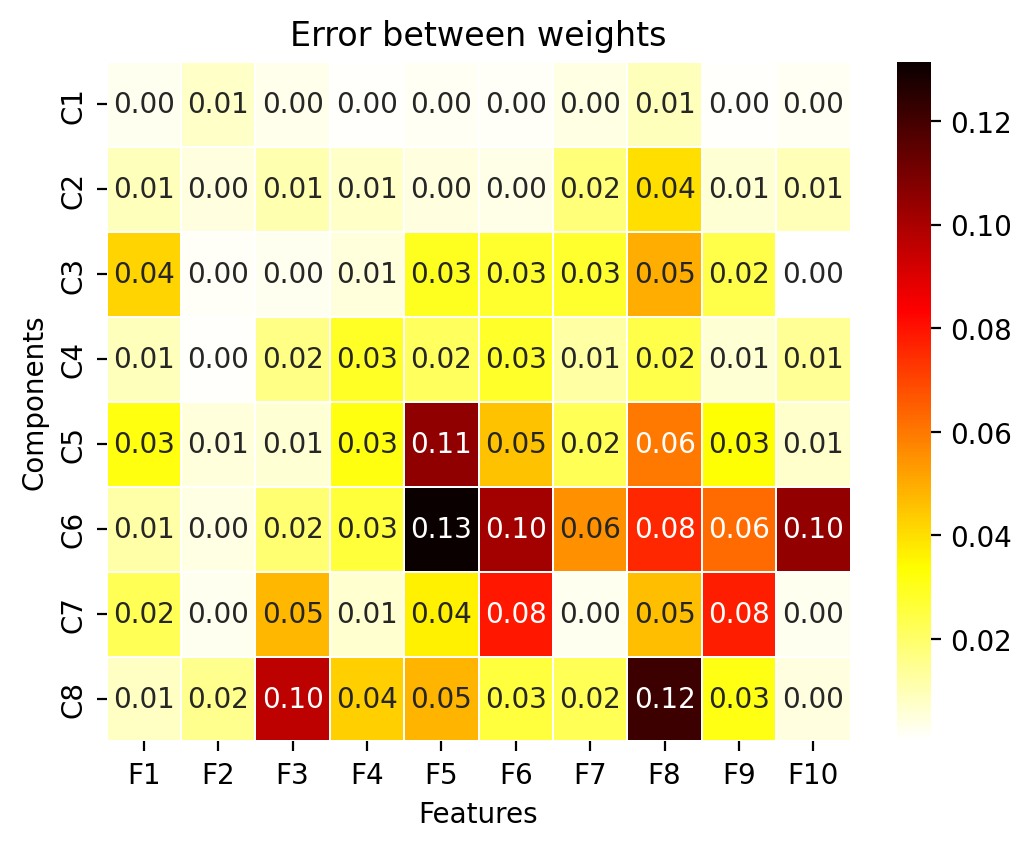

In [18]:
ours.create_heatmap(X_test[0], number_of_neighbours=150, auto_alpha=True, use_LIME=False)

Then, we are calculating the instance difference, and we plot the reduced instances by PCA and by DRx.

In [19]:
ours.find_reconstruction_error([X_test[0]], number_of_neighbours=150, auto_alpha=True, use_LIME=False)

mean_absolute_error =  1.3929724693810368e-05
cosine error =  2.8401458962434845e-10
euclidean error =  5.543678580386435e-05


(1.3929724693810368e-05, array([[2.8401459e-10]]), array([[5.54367858e-05]]))

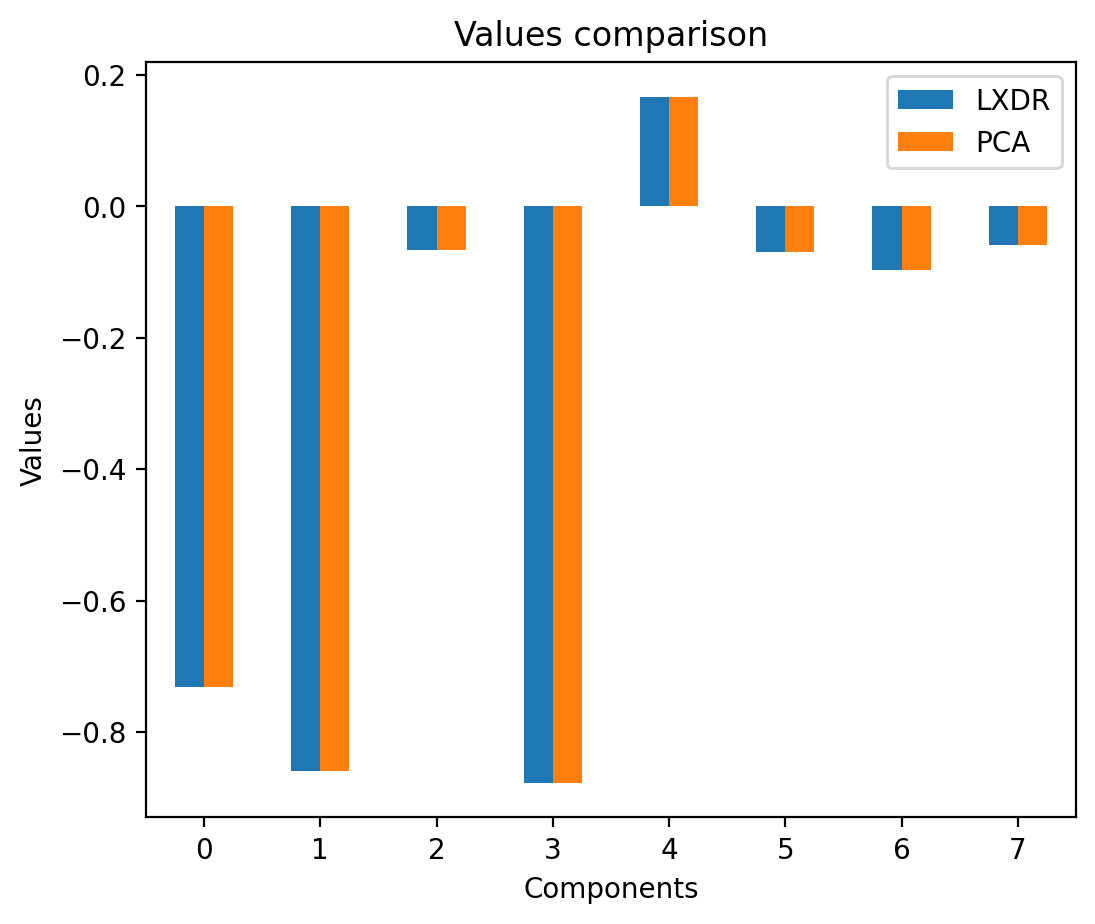

In [20]:
ours.visualise_reconstructed(X_test[0],
                          number_of_neighbours=150,
                          auto_alpha=True,
                          use_LIME=False)

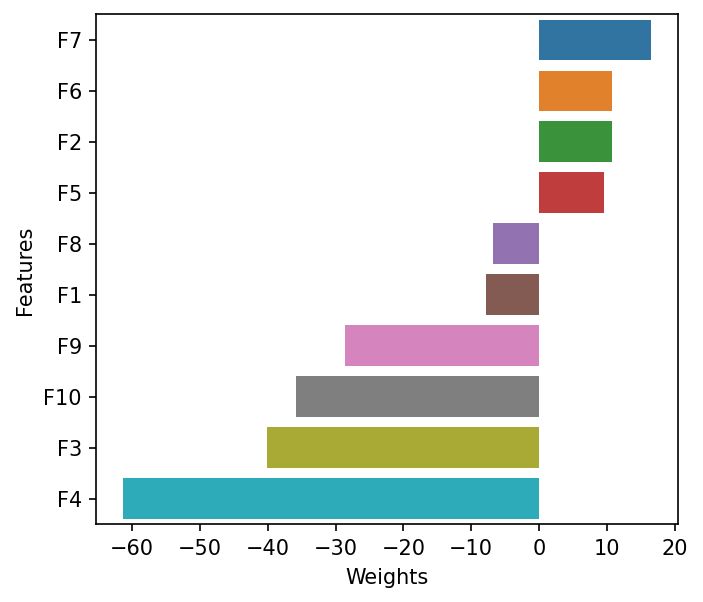

[-6.38, 62.08, -1.9, -65.04, -4.51, 3.85, 1.47, -1.51]

In [21]:
local = np.dot(clf.coef_*X_test_T[0],our_weights) + pca.mean_
model_weights = pd.DataFrame({"Features": ['F'+str(i) for i in range(1,11)], "Weights": list(local)}) #If you want to display global structure remove the * INSTANCE
model_weights = model_weights.sort_values(by="Weights", ascending=False)
#model_weights = model_weights[(model_weights["Weights"] != 0)]
#Moreover if there are many features you can take head 10 and tail 10 of the dataframe and display only 20 features
plt.figure(num=None, figsize=(5, 4.5), dpi=150, facecolor='w', edgecolor='k')
sns.barplot(x="Weights", y="Features", data=model_weights)
plt.xticks(rotation=0)
plt.show()
[round(i,2) for i in list(clf.coef_ * X_test_T[0])]

Which is identical!

## Use Case 2: Visualization
We examine one more use case. We will use PCA to project data to a lower dimension. Then, we will try to inspect an anomalous/outlier sample.

In [22]:
diabetes = datasets.load_diabetes()
initial_data = diabetes.data
initial_predictions = diabetes.target

#Reduce to 2 dimensions to enable visualisation
components = 2

#Random sample
sample = 68

We split our data

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(initial_data, initial_predictions, test_size=0.33, random_state=42)
scaler = MaxAbsScaler().fit(X_train)

We reduce the dimmensions to 2

In [24]:
kpca = KernelPCA(kernel='rbf', n_components=2)
kpca.fit(X_train)
X_train_v = kpca.transform(X_train)
X_test_v = kpca.transform(X_test)

We print the Scatter plot of our samples

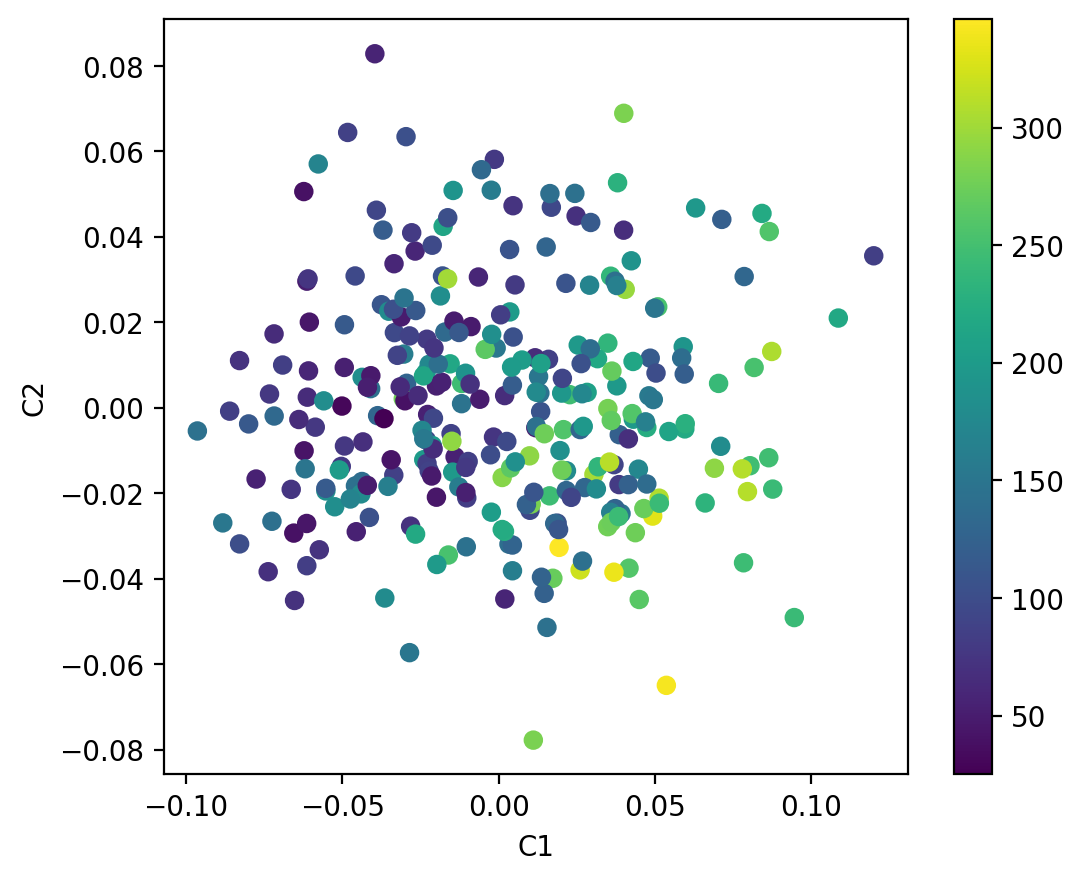

In [25]:
import seaborn as sns

plt.figure(dpi=200)
plt.xlabel('C1')
plt.ylabel('C2')
points = plt.scatter(X_train_v[:,0],X_train_v[:,1], c=y_train) #set style options
plt.colorbar(points)

We would like to see why the point in [0.27, 0.08] is there, while it should be on the other side of the plot!

In [26]:
np.argmax(X_train_v[:,0])

68

The point is the 68th point. We present its original and reduce representation

In [27]:
print('Instance: ', [round(i,2) for i in list(X_train[68])])
print('Reduced Representation: ', [round(i,2) for i in list(X_train_v[68])])

Instance:  [0.01, 0.05, 0.03, -0.0, 0.15, 0.2, -0.06, 0.19, 0.02, 0.07]
Reduced Representation:  [0.12, 0.04]


We want to know why the first dimension (0.27) got too far! Therefore, we multiply the original instance with the weights of the first component! Here we have the intrinsic weights of PCA, but if we were in KPCA, we would use LXDR

In [28]:
ours = LXDR(kpca, ['F'+str(i) for i in range(1,11)], 'local', X_train, False)

In [29]:
our_weights = ours.explain_instance(X_train[68], number_of_neghbours= 150,
                         auto_alpha=True,
                         use_LIME=False)

[round(i,2) for i in list(our_weights[0])]
#our_weights[0]*X_train[68], our_weights[0]

[0.08, 0.08, 0.14, 0.11, 0.16, 0.14, -0.11, 0.21, 0.16, 0.14]

The most important original feature seems to be the 8th!

In [30]:
temp = X_train[68].copy()
print(temp[7])
temp[7] = 0
temp_t = kpca.transform([temp,temp])
temp_t, initial_data[:,7].mean()
X_train_v[68] = temp_t[0]
[round(i,2) for i in list(temp_t[0])]

0.185234443260194


[0.08, 0.05]

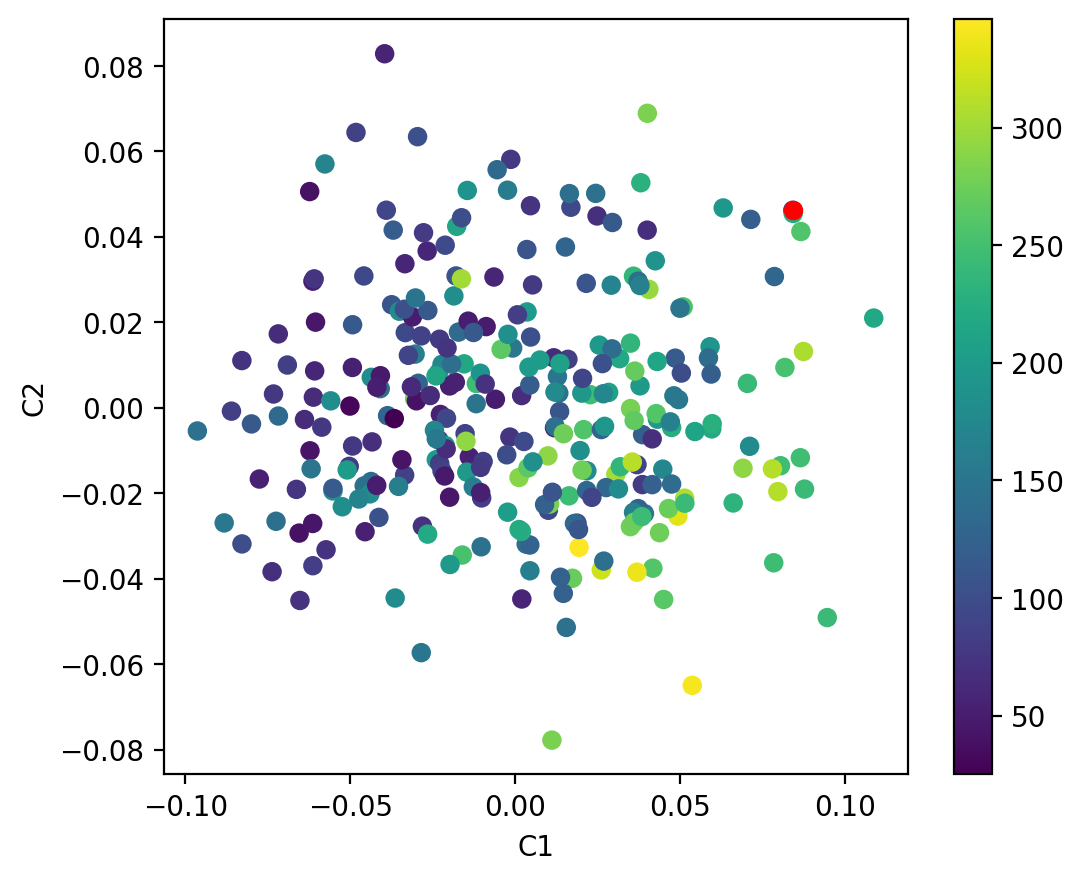

In [31]:
import seaborn as sns

plt.figure(dpi=200)
plt.xlabel('C1')
plt.ylabel('C2')
plt.plot(temp_t[0][0],temp_t[0][1], 'ro')
points = plt.scatter(X_train_v[:,0],X_train_v[:,1], c=y_train) #set style options
plt.colorbar(points)

Therefore, we can see that we managed to move the point inn a more suitable place. We can say now that we have to either examine the feature which was responsible for this point to not use it in our data, or to exclude this sample from the dataset.  